<a href="https://colab.research.google.com/github/NiketX05/ML_Project_Thapar/blob/main/AirCraft_Engine_Rul_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Install kagglehub if not already installed
!pip install kagglehub

import numpy as np
import pandas as pd
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from keras import models, layers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import kagglehub
import os

# Download Dataset
dataset_path = kagglehub.dataset_download("behrad3d/nasa-cmaps")
print("Dataset downloaded to:", dataset_path)

Using Colab cache for faster access to the 'nasa-cmaps' dataset.
Dataset downloaded to: /kaggle/input/nasa-cmaps


In [14]:
def loadData(dirPath=dataset_path):
    # Adjust path if CMaps subdirectory exists
    if os.path.exists(os.path.join(dirPath, 'CMaps')):
        dirPath = os.path.join(dirPath, 'CMaps/')
    else:
        if not dirPath.endswith('/'):
            dirPath += '/'

    print(f"Loading data from: {dirPath}")

    trainTxtFiles = ['train_FD001.txt', 'train_FD002.txt', 'train_FD003.txt', 'train_FD004.txt']
    testTxtFiles = ['test_FD001.txt', 'test_FD002.txt', 'test_FD003.txt', 'test_FD004.txt']
    rulTxtFiles = ['RUL_FD001.txt', 'RUL_FD002.txt', 'RUL_FD003.txt', 'RUL_FD004.txt']

    trainTestColumns = ['Unit Number', 'Time (Cycles)', 'OP1', 'OP2', 'OP3', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21']

    trainDatasets = []
    testDatasets = []
    expectedRulDatasets = []

    for i in range(4):
        tempTrain = pd.read_csv(dirPath + trainTxtFiles[i], sep=" ", header=None)
        tempTest = pd.read_csv(dirPath + testTxtFiles[i], sep=" ", header=None)
        tempRul = pd.read_csv(dirPath + rulTxtFiles[i], sep=" ", header=None)

        # Cleaning
        tempTrain.drop(inplace=True, columns=[26, 27])
        tempTest.drop(inplace=True, columns=[26, 27])
        tempRul.drop(inplace=True, columns=[1])

        # Naming Columns
        tempTrain.columns = tempTest.columns = trainTestColumns
        tempRul.columns = ["Expected RUL"]

        trainDatasets.append(tempTrain)
        testDatasets.append(tempTest)
        expectedRulDatasets.append(tempRul)

    return trainDatasets, testDatasets, expectedRulDatasets

def checkBasicStructure(trainDatasets, testDatasets, expectedRulDatasets):
    print("\nDatasets Example\n")
    for i in range(4):
        print("For FD00" + str(i+1))
        print("\nTrain Dataset")
        display(trainDatasets[i].head())
        print("\nTest Dataset")
        display(testDatasets[i].head())
        print("\nExpected RUL")
        display(expectedRulDatasets[i].head())
        print("\n")

def checkForNA(trainDatasets, testDatasets, expectedRulDatasets):
    print("\nDatasets Example\n")
    for i in range(4):
        print("For FD00" + str(i+1))
        print("\nTrain Dataset")
        display(trainDatasets[i].isna().sum())
        print("\nTest Dataset")
        display(testDatasets[i].isna().sum())
        print("\nExpected RUL")
        display(expectedRulDatasets[i].isna().sum())
        print("\n")

def checkRulBasicStructure(rulDatasets):
    print("\nRUL Datasets Example\n")
    for i in range(4):
        print("For FD00" + str(i+1))
        print("\nExpected RUL")
        display(rulDatasets[i].head())
        print("\n")

In [6]:
def findRul(Datasets):
    rulDatasets = []
    for i in range(4):
        temp = copy.deepcopy(Datasets[i].iloc[:, 0:2])
        tempRul = temp.groupby(Datasets[i].columns[0])[Datasets[i].columns[1]].max()
        tempRul = pd.DataFrame(tempRul)
        tempRul.columns = ["Max"]
        tempRul = pd.merge(temp, tempRul, left_on=Datasets[i].columns[0], right_on=Datasets[i].columns[0])
        tempRul["RUL"] = tempRul["Max"] - tempRul[Datasets[i].columns[1]]
        tempRul.drop(inplace=True, columns=["Max", Datasets[i].columns[1]])
        rulDatasets.append(tempRul)
    return rulDatasets

def processTrainingData(dataset, rulDataset=None, window=1, shift=1):
    partitions = int(np.floor((len(dataset) - window) / shift)) + 1
    features = dataset.shape[1]
    processedData = np.repeat(np.nan, repeats=partitions * window * features).reshape(partitions, window, features)

    if rulDataset is None:
        for i in range(partitions):
            processedData[i, :, :] = dataset[(0 + shift * i): (0 + shift * i + window), :]
        return processedData

    processedRul = np.repeat(np.nan, repeats=partitions)
    for i in range(partitions):
        processedData[i, :, :] = dataset[(0 + shift * i): (0 + shift * i + window), :]
        processedRul[i] = rulDataset[(shift * i + (window - 1))]

    return processedData, processedRul

def processTestingData(dataset, window, shift, testWindow=1):
    maxPartitions = int(np.floor((len(dataset) - window) / shift)) + 1

    if maxPartitions < testWindow:
        newLen = (maxPartitions - 1) * shift + window
        processedData = processTrainingData(dataset[-newLen:, :], window=window, shift=shift)
        return processedData, maxPartitions

    newLen = (testWindow - 1) * shift + window
    processedData = processTrainingData(dataset[-newLen:, :], window=window, shift=shift)
    return processedData, testWindow

def createModel(shape, name="Combined"):
    model = Sequential(name=name)
    model.add(LSTM(128, return_sequences=True, input_shape=(shape[1], shape[2])))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

In [15]:
trainDatasets, testDatasets, expectedRulDatasets = loadData()

# Check Basic Structure
checkBasicStructure(trainDatasets, testDatasets, expectedRulDatasets)

# Check For NAs
checkForNA(trainDatasets, testDatasets, expectedRulDatasets)

Loading data from: /kaggle/input/nasa-cmaps/CMaps/

Datasets Example

For FD001

Train Dataset


,Unit Number,Time (Cycles),OP1,OP2,OP3,S1,S2,S3,S4,S5,...,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044



Test Dataset


,Unit Number,Time (Cycles),OP1,OP2,OP3,S1,S2,S3,S4,S5,...,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130



Expected RUL


,Expected RUL
0,112
1,98
2,69
3,82
4,91




For FD002

Train Dataset


,Unit Number,Time (Cycles),OP1,OP2,OP3,S1,S2,S3,S4,S5,...,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286



Test Dataset


,Unit Number,Time (Cycles),OP1,OP2,OP3,S1,S2,S3,S4,S5,...,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21
0,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,...,371.69,2388.18,8114.10,8.6476,0.03,369,2319,100.00,28.42,17.1551
1,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,...,315.32,2388.12,8053.06,9.2405,0.02,364,2324,100.00,24.29,14.8039
2,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,...,183.04,2387.75,8053.04,9.3472,0.02,333,2223,100.00,14.98,8.9125
3,1,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,...,130.40,2387.72,8066.90,9.3961,0.02,332,2212,100.00,10.35,6.4181
4,1,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,...,164.56,2028.05,7865.66,10.8682,0.02,305,1915,84.93,14.31,8.5740



Expected RUL


,Expected RUL
0,18
1,79
2,106
3,110
4,15




For FD003

Train Dataset


,Unit Number,Time (Cycles),OP1,OP2,OP3,S1,S2,S3,S4,S5,...,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583



Test Dataset


,Unit Number,Time (Cycles),OP1,OP2,OP3,S1,S2,S3,S4,S5,...,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21
0,1,1,-0.0017,-0.0004,100.0,518.67,641.94,1581.93,1396.93,14.62,...,521.89,2387.94,8133.48,8.3760,0.03,391,2388,100.0,39.07,23.4468
1,1,2,0.0006,-0.0002,100.0,518.67,642.02,1584.86,1398.90,14.62,...,521.85,2388.01,8137.44,8.4062,0.03,391,2388,100.0,39.04,23.4807
2,1,3,0.0014,-0.0003,100.0,518.67,641.68,1581.78,1391.92,14.62,...,522.10,2387.94,8138.25,8.3553,0.03,391,2388,100.0,39.10,23.4244
3,1,4,0.0027,0.0001,100.0,518.67,642.20,1584.53,1395.34,14.62,...,522.45,2387.96,8137.07,8.3709,0.03,392,2388,100.0,38.97,23.4782
4,1,5,-0.0001,0.0001,100.0,518.67,642.46,1589.03,1395.86,14.62,...,521.91,2387.97,8134.20,8.4146,0.03,391,2388,100.0,39.09,23.3950



Expected RUL


,Expected RUL
0,44
1,51
2,27
3,120
4,101




For FD004

Train Dataset


,Unit Number,Time (Cycles),OP1,OP2,OP3,S1,S2,S3,S4,S5,...,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754



Test Dataset


,Unit Number,Time (Cycles),OP1,OP2,OP3,S1,S2,S3,S4,S5,...,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21
0,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,1227.81,9.35,...,313.03,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007
1,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,1031.48,7.05,...,163.61,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748
2,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,1105.88,3.91,...,129.98,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365
3,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,1107.26,3.91,...,129.48,2387.90,8078.89,9.3594,0.02,328,2212,100.00,10.56,6.2367
4,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,1117.80,5.48,...,181.82,2387.87,8057.83,9.3030,0.02,333,2223,100.00,14.85,8.9326



Expected RUL


,Expected RUL
0,22
1,39
2,107
3,75
4,149





Datasets Example

For FD001

Train Dataset


,0
Unit Number,0
Time (Cycles),0
OP1,0
OP2,0
OP3,0
S1,0
S2,0
S3,0
S4,0
S5,0



Test Dataset


,0
Unit Number,0
Time (Cycles),0
OP1,0
OP2,0
OP3,0
S1,0
S2,0
S3,0
S4,0
S5,0



Expected RUL


,0
Expected RUL,0




For FD002

Train Dataset


,0
Unit Number,0
Time (Cycles),0
OP1,0
OP2,0
OP3,0
S1,0
S2,0
S3,0
S4,0
S5,0



Test Dataset


,0
Unit Number,0
Time (Cycles),0
OP1,0
OP2,0
OP3,0
S1,0
S2,0
S3,0
S4,0
S5,0



Expected RUL


,0
Expected RUL,0




For FD003

Train Dataset


,0
Unit Number,0
Time (Cycles),0
OP1,0
OP2,0
OP3,0
S1,0
S2,0
S3,0
S4,0
S5,0



Test Dataset


,0
Unit Number,0
Time (Cycles),0
OP1,0
OP2,0
OP3,0
S1,0
S2,0
S3,0
S4,0
S5,0



Expected RUL


,0
Expected RUL,0




For FD004

Train Dataset


,0
Unit Number,0
Time (Cycles),0
OP1,0
OP2,0
OP3,0
S1,0
S2,0
S3,0
S4,0
S5,0



Test Dataset


,0
Unit Number,0
Time (Cycles),0
OP1,0
OP2,0
OP3,0
S1,0
S2,0
S3,0
S4,0
S5,0



Expected RUL


,0
Expected RUL,0


In [16]:
trainDatasetsCopy = copy.deepcopy(trainDatasets)
testDatasetsCopy = copy.deepcopy(testDatasets)
expectedRulDatasetsCopy = copy.deepcopy(expectedRulDatasets)

# Standardize Distribution
scaler = []
for i in range(4):
    sc = StandardScaler()
    scaler.append(sc)

for i in range(4):
    trainDatasetsCopy[i].iloc[:, 2:] = scaler[i].fit_transform(trainDatasetsCopy[i].iloc[:, 2:])
    testDatasetsCopy[i].iloc[:, 2:] = scaler[i].transform(testDatasetsCopy[i].iloc[:, 2:])

# Principal Component Analysis (PCA)
pca = PCA(n_components=10)
newColumns = ['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10']

for i in range(4):
    # Finding Principal Components
    temp1 = pca.fit_transform(trainDatasetsCopy[i].iloc[:, 2:])
    temp2 = pca.transform(testDatasetsCopy[i].iloc[:, 2:])

    # Converting to Dataframes
    temp1 = pd.DataFrame(temp1, columns=newColumns)
    temp2 = pd.DataFrame(temp2, columns=newColumns)

    # Dropping Excess Data & Merging New Data
    trainDatasetsCopy[i].drop(inplace=True, columns=trainDatasetsCopy[i].columns[2:])
    testDatasetsCopy[i].drop(inplace=True, columns=testDatasetsCopy[i].columns[2:])

    trainDatasetsCopy[i] = pd.merge(trainDatasetsCopy[i], temp1, left_index=True, right_index=True)
    testDatasetsCopy[i] = pd.merge(testDatasetsCopy[i], temp2, left_index=True, right_index=True)

checkBasicStructure(trainDatasetsCopy, testDatasetsCopy, expectedRulDatasetsCopy)

/tmp/ipython-input-1481679914.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.78170979 -0.78170979 -2.07309423 ...  3.09244354  1.15536688
  1.8010591 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trainDatasetsCopy[i].iloc[:, 2:] = scaler[i].fit_transform(trainDatasetsCopy[i].iloc[:, 2:])
/tmp/ipython-input-1481679914.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.78170979 -0.13601757 -0.13601757 ...  1.15536688  1.15536688
  1.8010591 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  testDatasetsCopy[i].iloc[:, 2:] = scaler[i].transform(testDatasetsCopy[i].iloc[:, 2:])
/tmp/ipython-input-1481679914.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.51557895 -0.6


Datasets Example

For FD001

Train Dataset


,Unit Number,Time (Cycles),PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,1,1,-2.952779,-0.432156,-1.172843,0.478171,0.668797,0.817216,0.637089,-0.347993,-0.030831,0.642404
1,1,2,-2.363669,-0.786872,-0.132349,1.153850,0.702399,0.976451,0.301464,-0.021018,0.316129,0.656538
2,1,3,-2.978665,-0.552466,-0.530408,-2.124418,-0.376082,0.572007,-1.122427,-0.461569,-0.254894,0.096212
3,1,4,-3.384151,-0.843788,0.255770,0.134290,0.337991,-0.399344,-0.050440,0.127225,0.115972,-1.127490
4,1,5,-2.428327,-0.363296,-1.024880,-0.306351,0.352159,-0.732400,0.355341,0.068085,0.488117,0.225827



Test Dataset


,Unit Number,Time (Cycles),PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,1,1,-2.475403,-0.777619,1.482786,0.080010,0.077868,-0.337896,-0.826615,0.921520,0.393515,-0.616565
1,1,2,-3.566323,-0.040873,-1.520490,-0.408165,0.459367,0.561212,1.260243,-0.117897,-0.206018,-0.495765
2,1,3,-2.336877,-0.379826,0.385361,-0.196137,0.169551,-0.050891,0.401225,0.680498,0.077260,1.011673
3,1,4,-2.850192,-0.810491,1.328483,1.310859,0.576017,-0.068813,-0.668261,0.035846,-0.225531,-0.174019
4,1,5,-3.494312,-0.752334,0.477794,0.370824,0.401362,0.567157,-1.189312,0.103837,0.134968,0.041174



Expected RUL


,Expected RUL
0,112
1,98
2,69
3,82
4,91




For FD002

Train Dataset


,Unit Number,Time (Cycles),PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,1,1,-2.193283,1.610639,-0.172923,-0.044703,-0.465595,-0.035497,0.086489,-0.084043,-0.072604,-0.042379
1,1,2,-2.960044,2.218475,0.234083,-0.010842,0.052701,-0.219312,0.081758,0.029655,0.009121,-0.013221
2,1,3,-5.997478,-4.311099,-0.009899,0.031464,-0.084929,-0.098735,0.011958,0.032155,-0.062204,0.050169
3,1,4,-2.973606,2.194856,0.229045,-0.015612,-0.010290,-0.219909,0.075195,0.073249,0.036594,-0.046409
4,1,5,-5.999720,-4.313578,-0.016556,0.043446,-0.089655,-0.152329,0.033390,-0.002800,-0.059059,0.055836



Test Dataset


,Unit Number,Time (Cycles),PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,1,1,3.771877,-0.275882,0.903953,0.178039,-0.215025,-0.208216,-0.155550,-0.003791,-0.021832,0.014226
1,1,2,1.582260,0.409099,-1.600337,0.018506,-0.032958,-0.128779,-0.153903,0.029624,-0.000802,-0.006236
2,1,3,-2.213299,1.609845,-0.160569,-0.063684,-0.486447,0.042858,0.062398,-0.025642,-0.035400,-0.027372
3,1,4,-2.949430,2.193961,0.199757,0.015900,0.046270,-0.262185,0.089598,0.015977,-0.054234,0.020710
4,1,5,-6.022637,-4.304434,0.026147,0.001671,-0.115800,-0.088908,0.022933,0.045629,-0.043022,-0.074625



Expected RUL


,Expected RUL
0,18
1,79
2,106
3,110
4,15




For FD003

Train Dataset


,Unit Number,Time (Cycles),PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,1,1,-1.366276,-0.371377,1.330873,-0.136651,-0.343447,1.057079,0.552070,-0.135855,0.366492,-0.125711
1,1,2,-0.894613,-0.158613,-0.985330,0.270185,0.354589,1.238571,0.348132,-0.243628,0.350986,0.302206
2,1,3,-1.056447,-0.147081,-0.534173,-0.719504,0.456698,1.201660,0.217314,-0.235968,0.050396,-0.758806
3,1,4,-0.741439,0.062070,0.371353,-0.890957,-0.194248,0.855163,0.279733,-0.461902,0.992138,0.551730
4,1,5,-0.616731,-1.081516,-0.025239,0.709367,0.077095,1.631234,-0.288941,0.781622,-0.543812,0.176199



Test Dataset


,Unit Number,Time (Cycles),PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,1,1,-2.162372,-1.838379,-1.264398,-0.865922,0.356273,-0.339945,-0.107751,0.009061,-0.089757,0.007523
1,1,2,-1.907783,-1.420004,-0.683069,0.234206,0.205843,-0.303783,-0.306239,0.262275,0.096927,-0.040463
2,1,3,-2.022972,-2.178672,-0.969285,0.548993,0.548613,0.052953,-0.484171,0.117500,-0.326351,-0.049353
3,1,4,-1.453940,-1.189275,0.263542,1.254994,0.115653,-0.059188,0.170727,0.020299,-0.054890,0.476296
4,1,5,-1.818713,-1.046527,0.312300,-0.004284,-0.119008,-0.455562,-0.351168,0.481077,0.875596,0.424866



Expected RUL


,Expected RUL
0,44
1,51
2,27
3,120
4,101




For FD004

Train Dataset


,Unit Number,Time (Cycles),PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,1,1,-3.015023,2.202168,0.212861,0.004079,0.012118,-0.119927,0.097312,-0.121166,0.026984,-0.033107
1,1,2,1.469597,0.389370,-1.624185,0.086131,-0.111275,-0.146623,-0.112017,-0.082148,0.021783,0.039646
2,1,3,-3.061170,2.154521,0.179298,0.045399,-0.010963,-0.190349,0.122244,-0.070166,0.062872,-0.025807
3,1,4,-3.012203,2.201073,0.261818,-0.026984,0.007403,-0.139130,0.065482,-0.108467,0.041192,-0.033449
4,1,5,-6.066693,-4.297044,-0.000600,0.022087,-0.126427,-0.035908,0.036928,-0.083133,-0.010179,0.011829



Test Dataset


,Unit Number,Time (Cycles),PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,1,1,1.455502,0.385731,-1.631894,0.091886,-0.114074,-0.113163,-0.122561,-0.087728,0.069559,0.079452
1,1,2,-6.090458,-4.329211,-0.022114,0.038731,-0.158762,-0.035487,0.017696,-0.113204,0.044688,0.025707
2,1,3,-3.098689,2.166248,0.201426,0.024057,-0.043218,-0.129818,0.099219,-0.123764,0.111120,-0.012944
3,1,4,-3.064131,2.212687,0.241819,-0.011640,0.005516,-0.085170,0.096632,-0.116447,0.077191,-0.027416
4,1,5,-2.262396,1.610898,-0.134049,-0.076948,-0.526831,0.050958,0.047500,-0.015184,0.046406,-0.042639



Expected RUL


,Expected RUL
0,22
1,39
2,107
3,75
4,149



RUL Datasets Example

For FD001

Expected RUL


,Unit Number,RUL
0,1,191
1,1,190
2,1,189
3,1,188
4,1,187




For FD002

Expected RUL


,Unit Number,RUL
0,1,148
1,1,147
2,1,146
3,1,145
4,1,144




For FD003

Expected RUL


,Unit Number,RUL
0,1,258
1,1,257
2,1,256
3,1,255
4,1,254




For FD004

Expected RUL


,Unit Number,RUL
0,1,320
1,1,319
2,1,318
3,1,317
4,1,316




For FD001



/tmp/ipython-input-1548349623.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.56517022 -1.55065208 -1.53613393 ...  1.29490444  1.30942258
  1.32394073]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trainDatasetsCopy[i].iloc[:, 1:] = scaler_model[i].fit_transform(trainDatasetsCopy[i].iloc[:, 1:])
/tmp/ipython-input-1548349623.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.56517022 -1.55065208 -1.53613393 ...  1.26586814  1.28038629
  1.29490444]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  testDatasetsCopy[i].iloc[:, 1:] = scaler_model[i].transform(testDatasetsCopy[i].iloc[:, 1:])
/tmp/ipython-input-1548349623.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.5

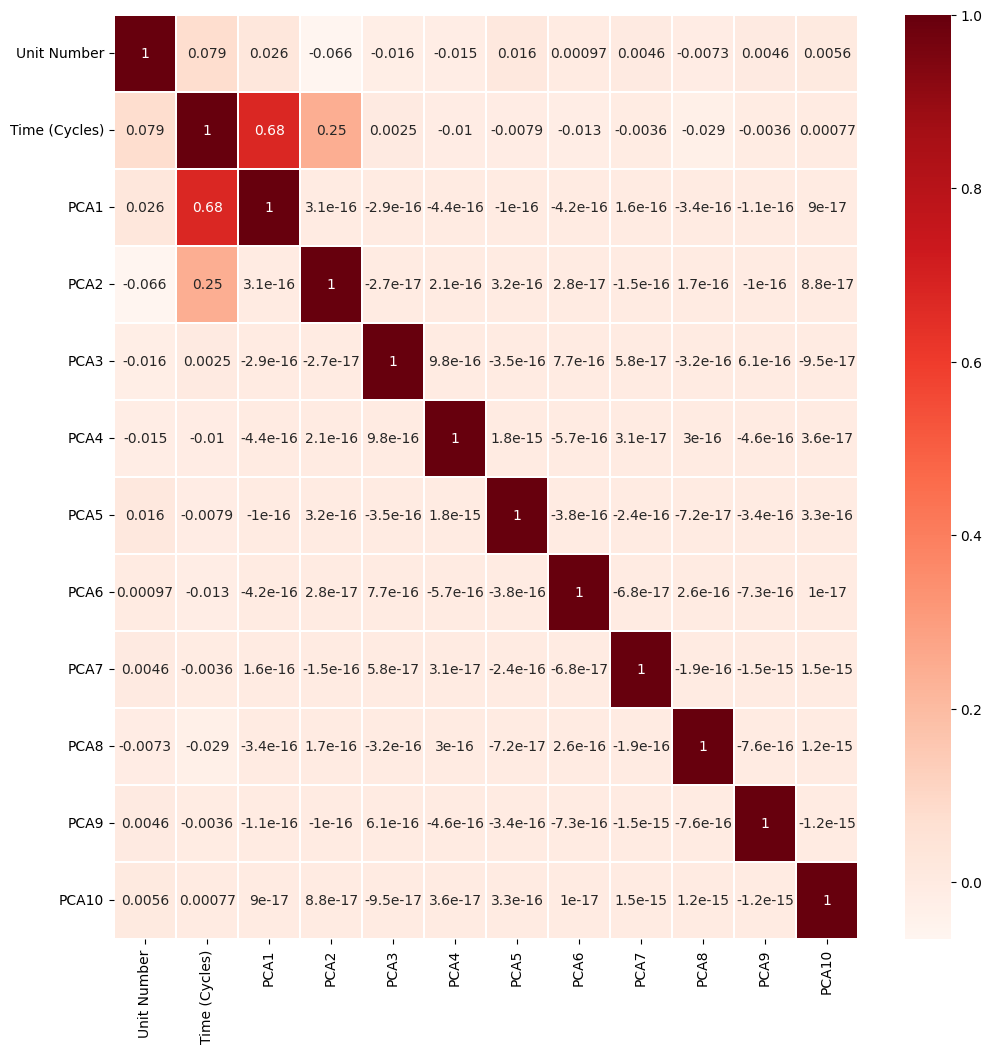



For FD002



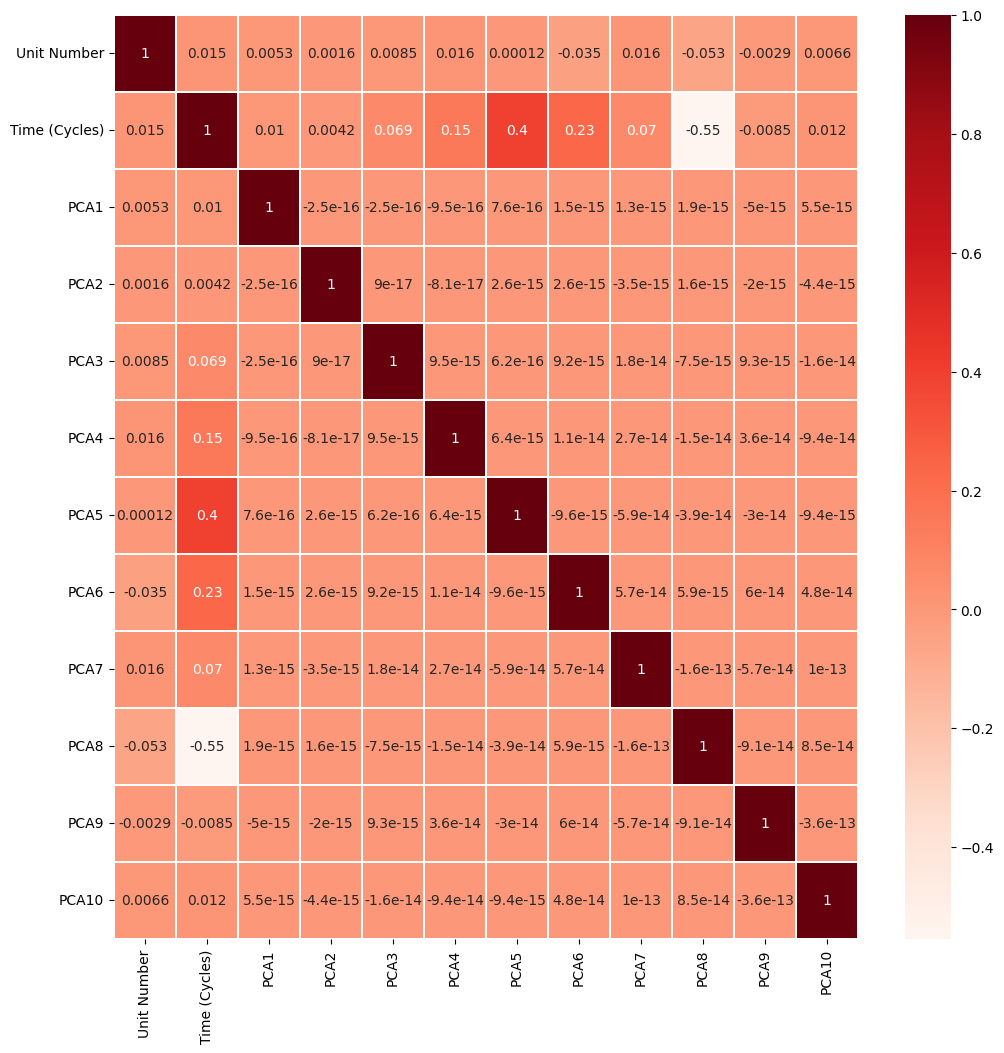



For FD003



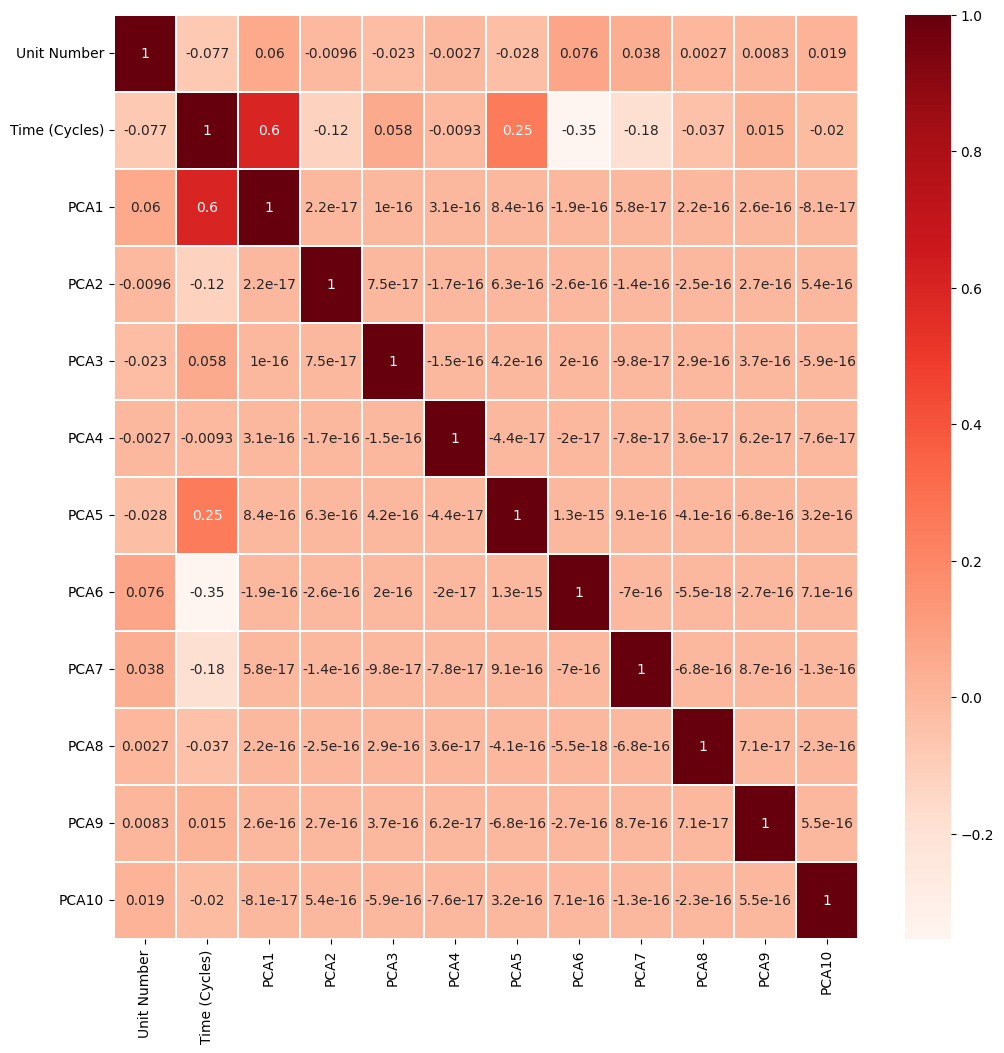



For FD004



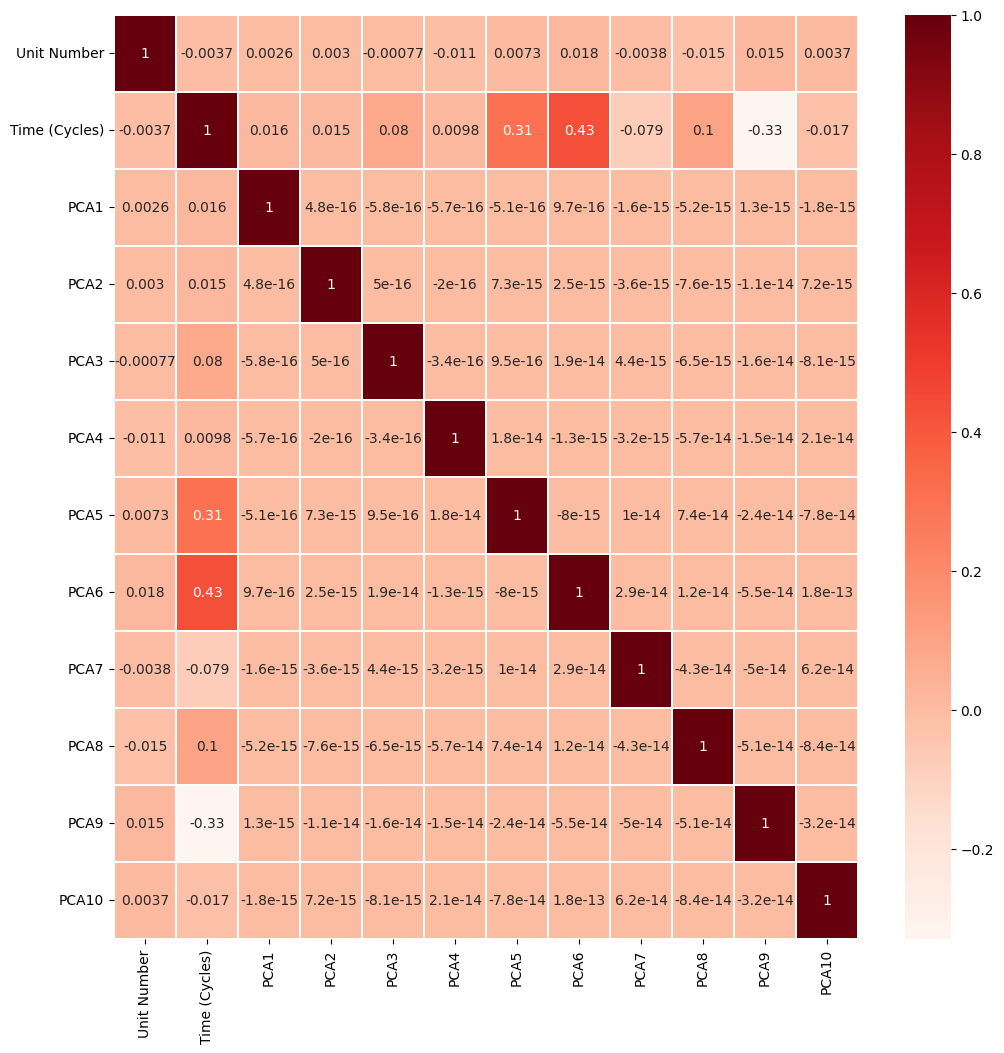

In [17]:
# Calculate RUL for training data
trainRulDatasets = findRul(trainDatasets)
checkRulBasicStructure(trainRulDatasets)

# Final Normalization (Time + PCA columns)
scaler_model = []
for i in range(4):
    sc = StandardScaler()
    scaler_model.append(sc)

for i in range(4):
    trainDatasetsCopy[i].iloc[:, 1:] = scaler_model[i].fit_transform(trainDatasetsCopy[i].iloc[:, 1:])
    testDatasetsCopy[i].iloc[:, 1:] = scaler_model[i].transform(testDatasetsCopy[i].iloc[:, 1:])

# Visualize Correlations
for i in range(4):
    print("For FD00" + str(i+1) + "\n")
    sns.heatmap(trainDatasetsCopy[i].corr(), annot=True, cmap="Reds", linewidths=0.2)
    fig = plt.gcf()
    fig.set_size_inches(12, 12)
    plt.show()
    print("\n")

In [18]:
defaultWindow = 10
defaultShift = 1
defaultTestWindow = 10

processedTrainDatasets = []
processedTestDatasets = []
processedTrainRulDatasets = []
rulDatasets = []
testWindowList = []

trainDatasetsUnique = [len(x['Unit Number'].unique()) for x in trainDatasetsCopy]
testDatasetsUnique = [len(x['Unit Number'].unique()) for x in testDatasetsCopy]

# Processing Training Data
for i in range(4):
    temp1 = []
    temp2 = []
    for j in range(1, trainDatasetsUnique[i]+1):
        tempTrainDataset = trainDatasetsCopy[i][trainDatasetsCopy[i]['Unit Number'] == j].drop(columns=['Unit Number']).values
        window_size = min(len(tempTrainDataset), defaultWindow)
        tempTrainRulDataset = trainRulDatasets[i][trainRulDatasets[i]['Unit Number'] == j].drop(columns=['Unit Number']).values

        tempTrainDataset, tempTrainRulDataset = processTrainingData(tempTrainDataset, tempTrainRulDataset, window=window_size, shift=defaultShift)
        temp1.append(tempTrainDataset)
        temp2.append(tempTrainRulDataset)

    processedTrainDatasets.append(np.concatenate(temp1))
    processedTrainRulDatasets.append(np.concatenate(temp2))

# Processing Test Data
for i in range(4):
    temp1 = []
    temp2 = []
    for j in range(1, testDatasetsUnique[i]+1):
        tempTestDataset = testDatasetsCopy[i][testDatasetsCopy[i]['Unit Number'] == j].drop(columns=['Unit Number']).values
        window_size = min(len(tempTestDataset), defaultWindow)

        tempTestDataset, testWindow = processTestingData(tempTestDataset, window=window_size, shift=defaultShift, testWindow=defaultTestWindow)
        temp1.append(tempTestDataset)
        temp2.append(testWindow)

    processedTestDatasets.append(np.concatenate(temp1))
    testWindowList.append(temp2)
    rulDatasets.append(expectedRulDatasetsCopy[i]["Expected RUL"].values)

# Check Shapes
for i in range(4):
    print(f"For FD00{i+1}: Train Shape {processedTrainDatasets[i].shape}, Test Shape {processedTestDatasets[i].shape}")

/tmp/ipython-input-2875805003.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  processedRul[i] = rulDataset[(shift * i + (window - 1))]
/tmp/ipython-input-2875805003.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  processedRul[i] = rulDataset[(shift * i + (window - 1))]
/tmp/ipython-input-2875805003.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  processedRul[i] = rulDataset[(shift * i + (window - 1))]
/tmp/ipython-input-2875805003.py:27: DeprecationW

For FD001: Train Shape (19731, 10, 11), Test Shape (1000, 10, 11)
For FD002: Train Shape (51419, 10, 11), Test Shape (2590, 10, 11)
For FD003: Train Shape (23820, 10, 11), Test Shape (1000, 10, 11)
For FD004: Train Shape (59008, 10, 11), Test Shape (2480, 10, 11)


In [19]:
trainedModel = []
histories = []

for i in range(4):
    print("For FD00" + str(i+1) + "\n")
    name = "FD00" + str(i+1)
    model = createModel(processedTrainDatasets[i].shape, name=name)
    model.summary()
    history = model.fit(processedTrainDatasets[i], processedTrainRulDatasets[i], epochs=100, validation_split=0.2, batch_size=256, verbose=1)
    print("\n")
    trainedModel.append(model)
    histories.append(history)


For FD001



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "FD001"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 10, 128)        │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,537 (521.63 KB)

 Trainable params: 133,537 (521.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 13402.7197 - val_loss: 17146.3438
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12597.4717 - val_loss: 16649.5742
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11994.9746 - val_loss: 16212.3057
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 11660.5400 - val_loss: 15801.6084
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 11412.5166 - val_loss: 15408.4609
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11090.8467 - val_loss: 15033.6123
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10774.7832 - val_loss: 14670.9727
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10329.5957 - val_loss: 14322.3721
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10047.6992 - val_loss: 13984.9375
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9494.0869 - val_loss: 13659.3857
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9401.77

Model: "FD002"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 10, 128)        │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,537 (521.63 KB)

 Trainable params: 133,537 (521.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 14124.1924 - val_loss: 12576.9785
Epoch 2/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12581.8887 - val_loss: 11628.3809
Epoch 3/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11691.8740 - val_loss: 10756.8779
Epoch 4/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10827.7852 - val_loss: 9989.0576
Epoch 5/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10103.6660 - val_loss: 9299.1357
Epoch 6/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9346.4727 - val_loss: 8675.7568
Epoch 7/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8760.3301 - val_loss: 8113.7783
Epoch 8/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8191.5088 - val_loss: 7607.3682
Epoch 9/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 7731.9292 - val_loss: 7154.3125
Epoch 10/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7292.3223 - val_loss: 6555.4165
Epoch 11/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - los

Model: "FD003"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 10, 128)        │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,537 (521.63 KB)

 Trainable params: 133,537 (521.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 25920.3320 - val_loss: 26298.3574
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 24879.4258 - val_loss: 25609.8223
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 24268.3828 - val_loss: 24953.2871
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 23729.6855 - val_loss: 24323.9531
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 23163.7012 - val_loss: 23729.5332
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 22507.1191 - val_loss: 23155.6191
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 21487.5039 - val_loss: 22606.4766
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 21391.6191 - val_loss: 22073.0957
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 20753.5801 - val_loss: 21556.0547
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 19941.9727 - val_loss: 21055.9316
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19613.1

Model: "FD004"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 10, 128)        │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,537 (521.63 KB)

 Trainable params: 133,537 (521.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 23545.4160 - val_loss: 19547.4336
Epoch 2/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 21361.0332 - val_loss: 18191.4121
Epoch 3/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 19934.5469 - val_loss: 16973.4531
Epoch 4/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 18725.8418 - val_loss: 15860.0156
Epoch 5/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 17556.5996 - val_loss: 14843.5684
Epoch 6/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 16653.5938 - val_loss: 13910.2783
Epoch 7/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 15350.1572 - val_loss: 13058.3535
Epoch 8/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 14586.7021 - val_loss: 12282.5566
Epoch 9/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13883.1299 - val_loss: 11331.7480
Epoch 10/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12829.2871 - val_loss: 10573.1504
Epoch 11/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
For FD001 -> RMSE: 28.371290026603404, R2: 0.5338790504079487
For FD002 -> RMSE: 31.753878386972243, R2: 0.6513646393817385
For FD003 -> RMSE: 34.3415270894394, R2: 0.311775131550896
For FD004 -> RMSE: 42.48071860024545, R2: 0.3929680007546009
For FD001


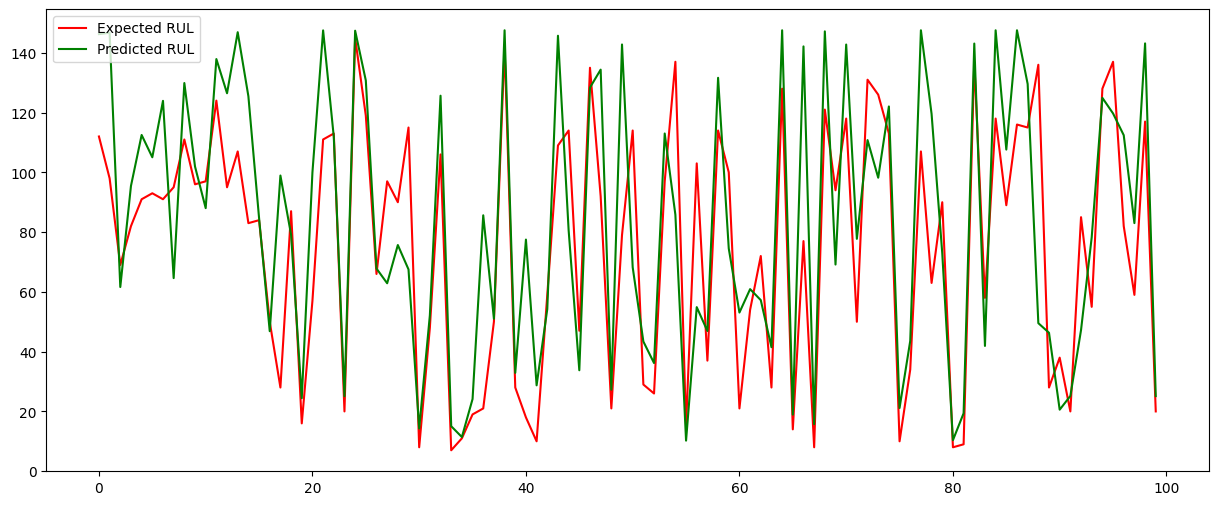

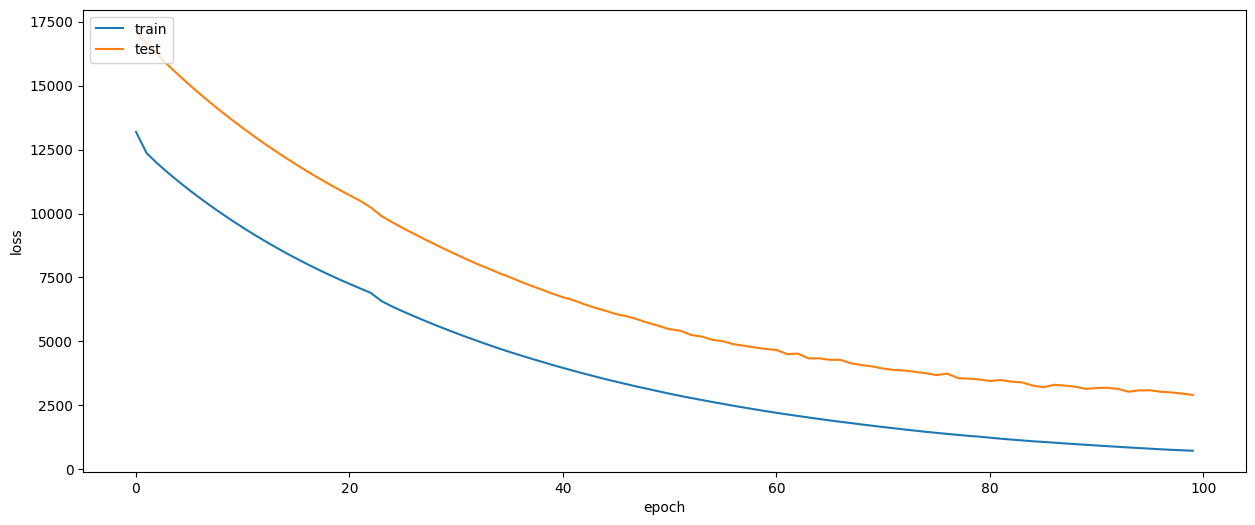

For FD002


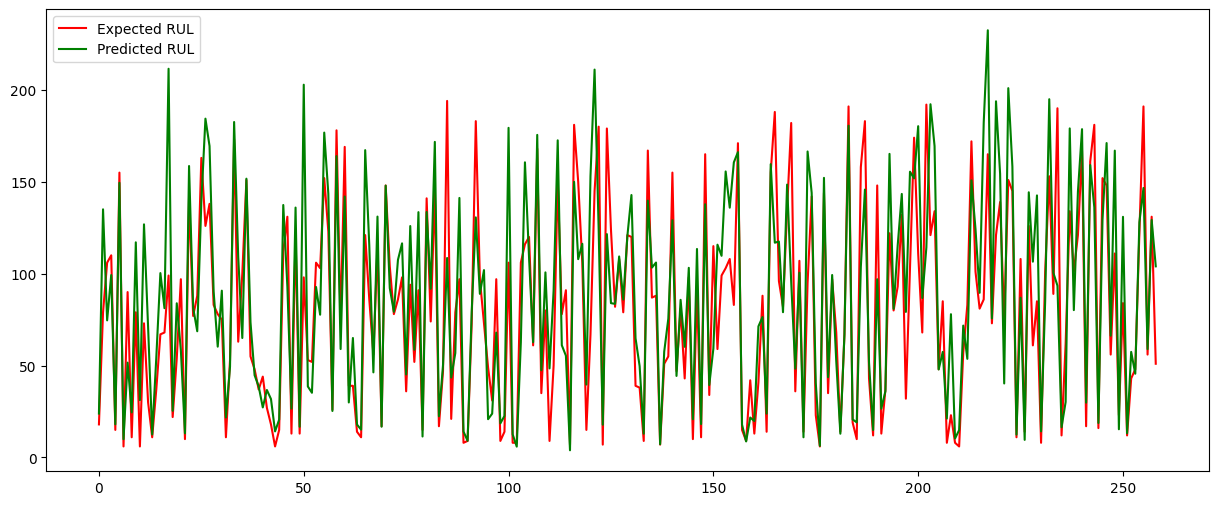

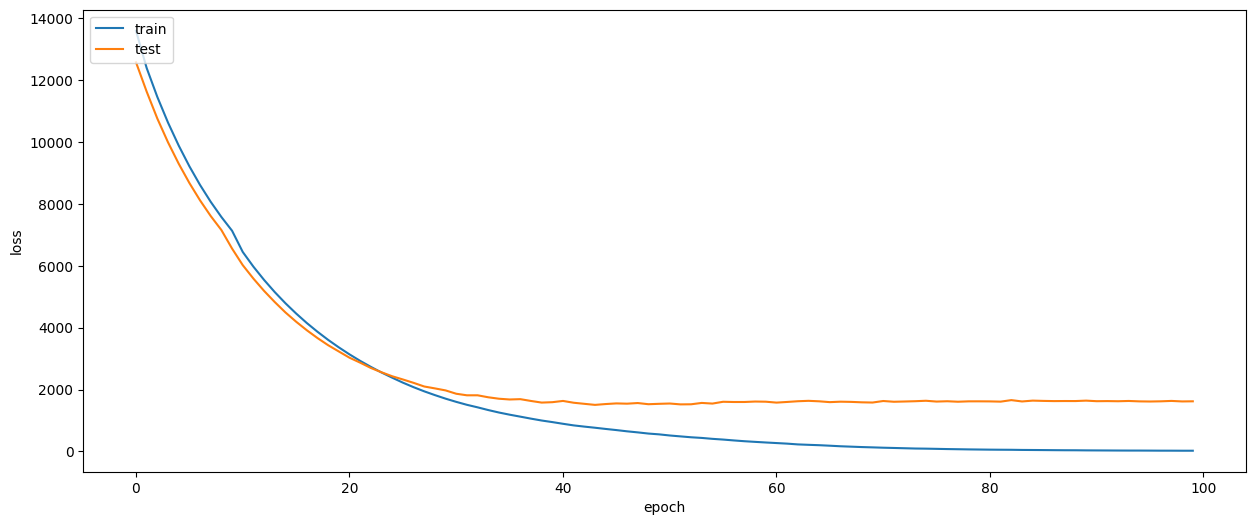

For FD003


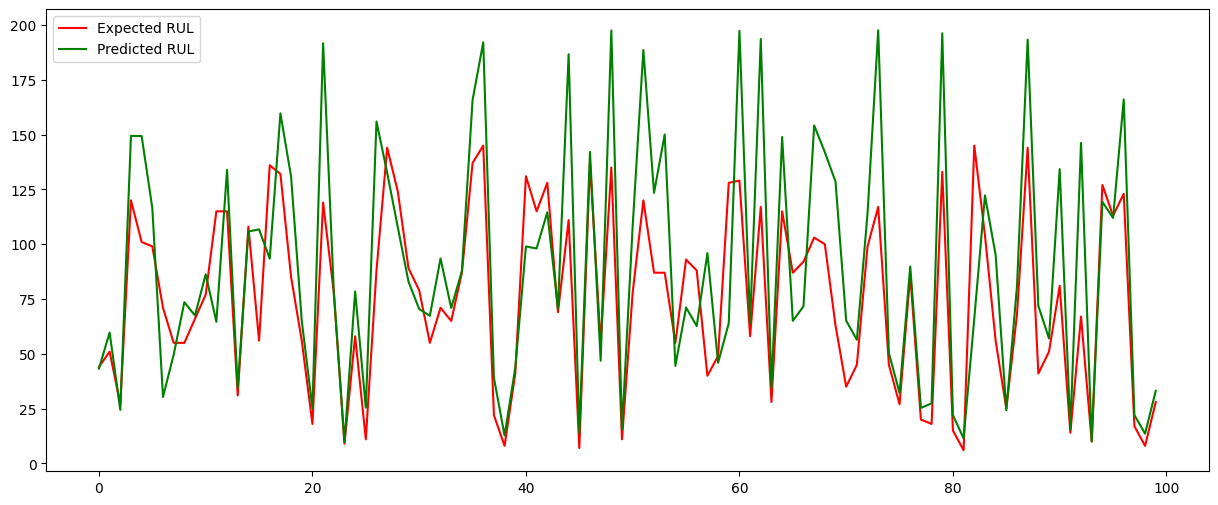

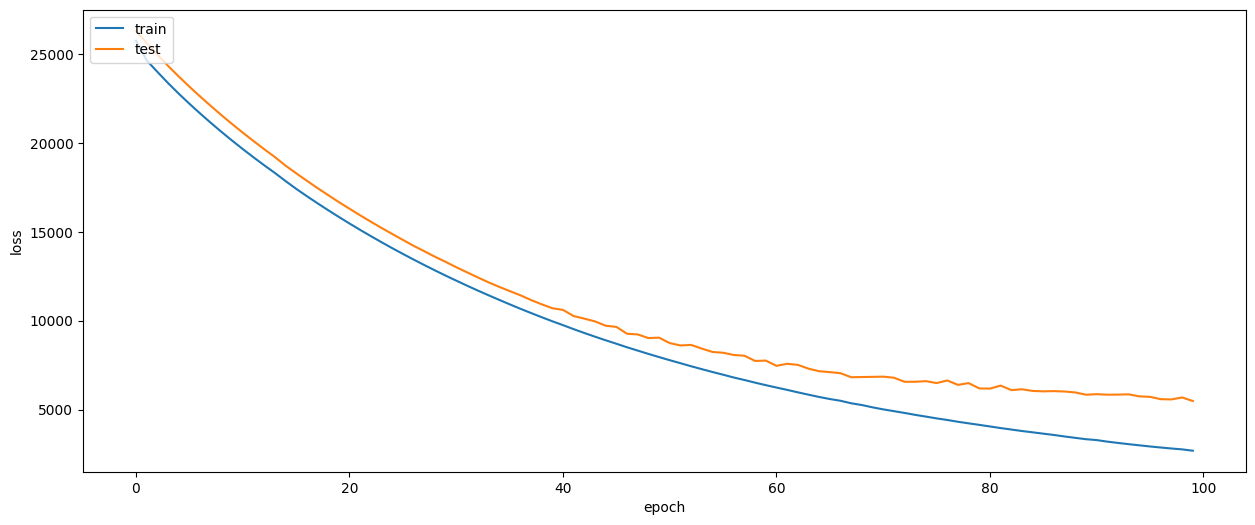

For FD004


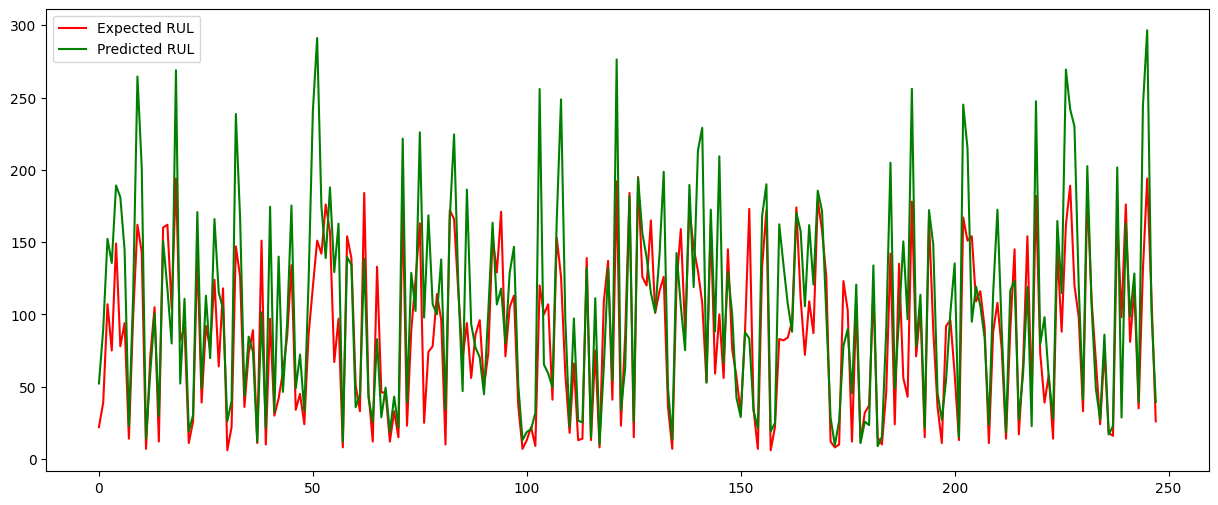

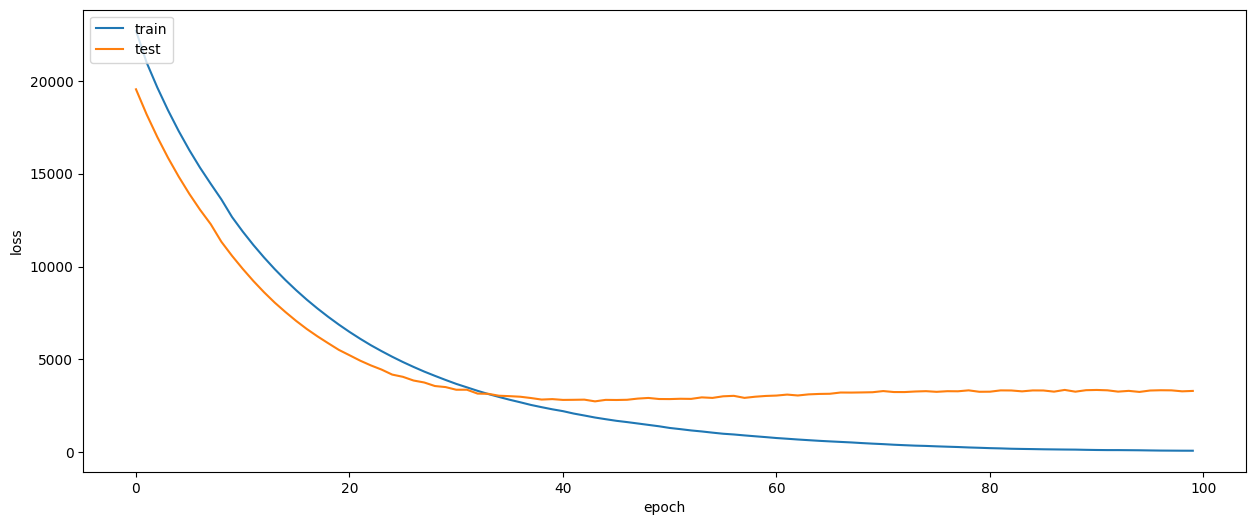

In [20]:
predictedRulDatasets = []
rmseList = []
r2_scoreList = []

# Predicting
for i in range(4):
    predictedRul = trainedModel[i].predict(processedTestDatasets[i]).reshape(-1)
    predictedRul = np.split(predictedRul, np.cumsum(testWindowList[i])[:-1])
    predictedRul = [np.average(ruls, weights=np.repeat(1/testWindow, testWindow)) for ruls, testWindow in zip(predictedRul, testWindowList[i])]
    predictedRulDatasets.append(predictedRul)

# Metrics
for i in range(4):
    rmse = np.sqrt(mse(rulDatasets[i], predictedRulDatasets[i]))
    r2_sc = r2_score(rulDatasets[i], predictedRulDatasets[i])
    print(f"For FD00{i+1} -> RMSE: {rmse}, R2: {r2_sc}")
    rmseList.append(rmse)
    r2_scoreList.append(r2_sc)

# Visualization
for i in range(4):
    print("For FD00" + str(i+1))
    plt.figure(figsize=(15, 6))
    plt.plot(rulDatasets[i], label="Expected RUL", color="Red")
    plt.plot(predictedRulDatasets[i], label="Predicted RUL", color="Green")
    plt.legend(loc='upper left')
    plt.show()

    plt.figure(figsize=(15, 6))
    plt.plot(histories[i].history['loss'])
    plt.plot(histories[i].history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
963/963 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 16717.9336 - val_loss: 16331.3643
Epoch 2/100
963/963 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 11421.9492 - val_loss: 11914.8652
Epoch 3/100
963/963 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 8169.8667 - val_loss: 8890.5928
Epoch 4/100
963/963 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 5911.2358 - val_loss: 6786.5898
Epoch 5/100
963/963 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 4271.8242 - val_loss: 5385.0825
Epoch 6/100
963/963 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 3301.2437 - val_loss: 4503.2661
Epoch 7/100
963/963 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 2650.8774 - val_loss: 3949.0247
Epoch 8/100
963/963 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 2207.5420 - val_loss: 3575.9849
Epoch 9/100
963/963 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 1893.3896 - val_loss: 3399.1709
Epoch 10/100
963/963 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 1621.5819 - val_loss: 3392.9871
Epoch 11/100
963/963 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 14

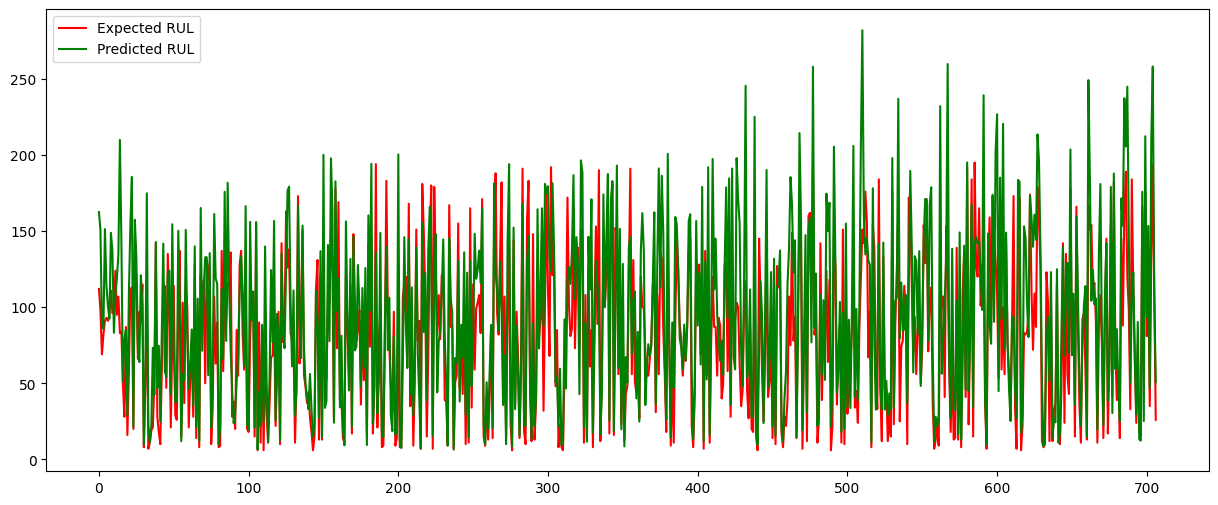

In [21]:
# Concatenate Data
completeTrainDatasets = np.concatenate(processedTrainDatasets)
completeTrainRulDatasets = np.concatenate(processedTrainRulDatasets)
completeTestDatasets = np.concatenate(processedTestDatasets)
completeRulDatasets = np.concatenate(rulDatasets)
completeTestWindowList = np.concatenate(testWindowList)

# Train Model
completeModel = createModel(completeTrainDatasets.shape)
completeHistory = completeModel.fit(completeTrainDatasets, completeTrainRulDatasets, epochs=100, validation_split=0.2, batch_size=128, verbose=1)

# Predict
completePredictedRul = completeModel.predict(completeTestDatasets).reshape(-1)
completePredictedRul = np.split(completePredictedRul, np.cumsum(completeTestWindowList)[:-1])
completePredictedRul = [np.average(ruls, weights=np.repeat(1/testWindow, testWindow)) for ruls, testWindow in zip(completePredictedRul, completeTestWindowList)]

# Metrics
rmse = np.sqrt(mse(completeRulDatasets, completePredictedRul))
r2_sc = r2_score(completeRulDatasets, completePredictedRul)
print(f"Combined Model -> RMSE: {rmse}, R2: {r2_sc}")

# Visualization
plt.figure(figsize=(15, 6))
plt.plot(completeRulDatasets, label="Expected RUL", color="Red")
plt.plot(completePredictedRul, label="Predicted RUL", color="Green")
plt.legend(loc='upper left')
plt.show()

In [22]:
modelDumpFolder = '/content/' # Standard Colab working directory
modelDumpFiles = ['FD001.pkl', 'FD002.pkl', 'FD003.pkl', 'FD004.pkl', 'complete.pkl']

# Save Individual Models
for i in range(4):
    pickle.dump(trainedModel[i], open(modelDumpFolder + modelDumpFiles[i], 'wb'))

# Save Complete Model
# Note: Fixed the index variable 'i' to explicitly point to the last file
pickle.dump(completeModel, open(modelDumpFolder + modelDumpFiles[4], 'wb'))

print("Models saved successfully.")

Models saved successfully.
